# A. Import libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import string
import itertools

from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import keras
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

# B. Load Data

In [ ]:
# Read from csv files
true = pd.read_csv("drive/MyDrive/Temporary/data/True.csv")
fake = pd.read_csv("drive/MyDrive/Temporary/data/Fake.csv")

In [ ]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
# Set category values & concatenate datasets
true['category'] = 1
fake['category'] = 0
df = pd.concat([true,fake])

In [ ]:
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


# C. Data Visualization & Preprocessing

#### 1 Visualization

In [ ]:
# Number of data instances
len(df)

44898

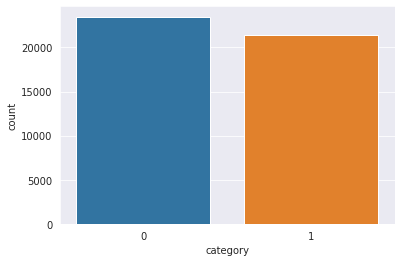

In [ ]:
# Check true vs fake news balance
# Dataset is balanced
sns.set_style("darkgrid")
sns.countplot(x=df.category)

In [ ]:
# Check for nan values
# No NaN values present
df.isna().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

[Text(0, 0, 'politicsNews'),
 Text(0, 0, 'worldnews'),
 Text(0, 0, 'News'),
 Text(0, 0, 'politics'),
 Text(0, 0, 'Government News'),
 Text(0, 0, 'left-news'),
 Text(0, 0, 'US_News'),
 Text(0, 0, 'Middle-east')]

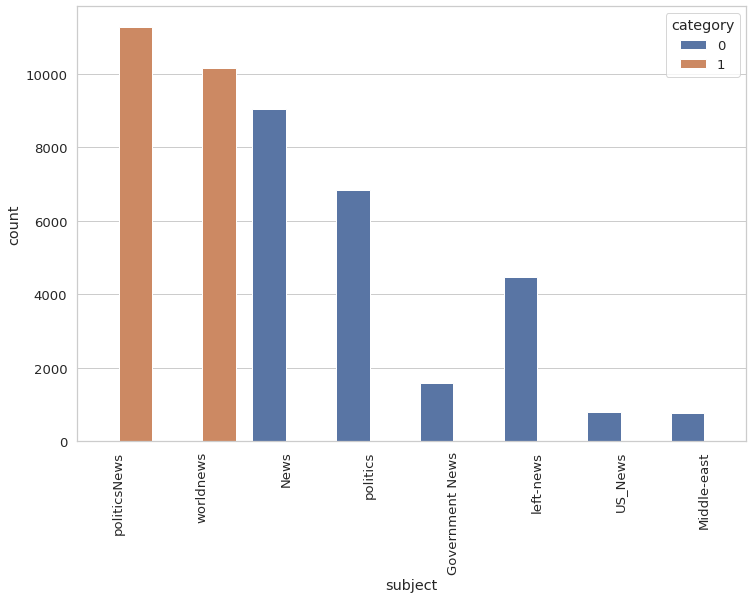

In [ ]:
# Plot countplot for category
# To check if category is relevant
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", hue = "category" , data = df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

In [ ]:
# Since the topics in subject column are different for both true & fake categories, the 'category' column is redundant.
# Hence we merge all the text data into 1 column i.e. 'text' & remove redundant columns.
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']
df.head()

,text,category
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


#### 2 Clean Data

In [ ]:
def denoise_text(text):
    text = re.sub('\[[^]]*\]', '', text)  # Remove square brackets
    text = re.sub("[^\w]", " ",text)      # Remove square brackets
    text = re.sub(r"\.", " ", text)       # Remove periods
    text = re.sub(r'http\S+', '', text)   # Remove urls
    text = re.sub(r"!", " ! ", text)      # Remove exclamations
    text = re.sub(r"\/", " ", text)       # Remove forward slash
    text = re.sub(r"\^", " ^ ", text)     # Remove exponent symbol
    text = re.sub(r"\+", " + ", text)     # Remove addition symbol
    text = re.sub(r"\-", " - ", text)     # Remove hyphens
    text = re.sub(r"\=", " = ", text)     # Remove equal symbol
    return text

df['text'] = df['text'].apply(lambda s:s.lower() if type(s) == str else s) # Convert to lowercase
df['text'] = df['text'].apply(denoise_text)

#### 3 Stopwords Removal

In [ ]:
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

df['text'] = df['text'].apply(remove_stopwords)

In [ ]:
df.head()

,text,category
0,washington reuters head conservative republica...,1
1,washington reuters transgender people allowed ...,1
2,washington reuters special counsel investigati...,1
3,washington reuters trump campaign adviser geor...,1
4,seattle washington reuters president donald tr...,1


# D. Data Representation

#### Split data into train & test set

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.category, test_size=0.2, random_state=42)

### 1 Bag of Words

In [ ]:
bow_vectorizer = CountVectorizer(ngram_range=(1,1))

In [ ]:
bow_train = bow_vectorizer.fit_transform(x_train)
bow_test = bow_vectorizer.transform(x_test)

In [ ]:
# 10 vocabulary items
list(bow_vectorizer.vocabulary_.items())[:10]

[('story', 94442),
 ('2006', 1364),
 ('first', 38630),
 ('long', 60103),
 ('series', 88963),
 ('hillary', 46849),
 ('lies', 59186),
 ('exposing', 36664),
 ('next', 69425),
 ('couple', 26271)]

### 2 TF IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

In [ ]:
tfidf_train = tfidf_vectorizer.fit_transform(x_train) 
tfidf_test = tfidf_vectorizer.transform(x_test)

In [ ]:
# 10 vocabulary items
list(tfidf_vectorizer.vocabulary_.items())[:10]

[('story', 94292),
 ('2006', 1364),
 ('long', 60010),
 ('series', 88828),
 ('hillary', 46768),
 ('lies', 59093),
 ('exposing', 36604),
 ('couple', 26233),
 ('months', 66277),
 ('decade', 28629)]

### 3 GloVe Embeddings

In [ ]:
max_features = 10000
maxlen = 300

In [ ]:
# fitting tokenizer on train dataset
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
# generating the sequences using tokenizer now
tokenized_train = tokenizer.texts_to_sequences(x_train)
# padding sequences here to max_len specified above i.e. 300
X_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)


In [ ]:
print(len(tokenized_train))
print(len(x_train))

35918
35918


In [ ]:
#checking the output corresponding to the text
print(x_train[0:5])
print(tokenized_train[0:5])

14918    story 2006 first long series hillary lies expo...
12384    paris reuters leaders european union remaining...
3002     star wars icon mark hamill previously mocked d...
3323     whiner chief struck yet another early morning ...
5622     donald trump much foreign policy experience lo...
Name: text, dtype: object
[[196, 2672, 32, 129, 1119, 34, 1186, 4102, 136, 1409, 232, 1467, 7, 1518, 145, 34, 8663, 12, 7555, 1038, 5959, 34, 5601, 196, 37, 8004, 62, 12, 1778, 2417, 12, 25, 2, 1038, 5959, 7597, 190, 196, 1022, 1516, 8172, 1180, 256, 1021, 257, 1965, 2, 5423, 980, 25, 44, 5959, 5785, 853, 32, 360, 1244, 1288, 5601, 5063, 2081, 164, 5959, 2417, 12, 2, 1022, 8663, 129, 23, 1038, 3271, 27, 3069, 608, 1582, 6555, 34, 2417, 12, 2, 28, 164, 5959, 1189, 74, 34, 655, 23, 5959, 34, 37, 273, 62, 12, 2245, 196, 3403, 316, 34, 12, 1787, 967, 375, 976, 3002, 7, 294, 4473, 196, 40, 2881, 5959, 853, 3271, 2417, 12, 1709, 1189, 75, 5893, 34, 1186, 1205, 34, 3586, 1038, 3271, 347], [923, 14, 197,

In [ ]:
# generating the sequences for the test data
tokenized_test = tokenizer.texts_to_sequences(x_test)
# doing padding over the test data
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [ ]:
word_index=tokenizer.word_index

In [ ]:
word_index['story']

196

In [ ]:
EMBEDDING_FILE = 'drive/MyDrive/Temporary/data/glove.6B.100d.txt'

In [ ]:
# reading the glove file
embedding_dict={}
with open(EMBEDDING_FILE) as f:
  for item in f:
    values = item.split()
    word=values[0]
    vectors = np.asarray(values[1:],"float32")
    embedding_dict[word] = vectors
f.close()

In [ ]:
#making the embedding matrix here
num_words = len(word_index) + 1
embedding_matrix = np.zeros((max_features,100))
for word,i in word_index.items():
  if(i<max_features):
    emb_vec = embedding_dict.get(word)
    if(emb_vec is not None):
      embedding_matrix[i] = emb_vec

In [ ]:
num_words

110519

In [ ]:
#checking the entries are same at both the places or not
(embedding_matrix[196] == embedding_dict["story"]).all()

True

In [ ]:
embedding_matrix.shape

(10000, 100)

# E. Models

### Logistic Regression (using BoW)

In [ ]:
logregBOW = LogisticRegression(max_iter=10000)
logregBOW.fit(bow_train, y_train)
score = logregBOW.score(bow_test, y_test)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 99.59%


In [ ]:
pred_logreg_bow = logregBOW.predict(bow_test)
confusion_matrix(y_test, pred_logreg_bow)

array([[4625,   25],
       [  12, 4318]])

### Multinomial Naive Bayes (using BoW)

In [ ]:
nbBOW = MultinomialNB()
nbBOW.fit(bow_train, y_train)
score = nbBOW.score(bow_test, y_test)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 95.43%


In [ ]:
pred_nb_bow = nbBOW.predict(bow_test)
confusion_matrix(y_test, pred_nb_bow)

array([[4428,  222],
       [ 188, 4142]])

### SVM (using BOW)

In [ ]:
clfBOW = SVC(kernel='linear') 
clfBOW.fit(bow_train,y_train) 
score = clfBOW.score(bow_test, y_test)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 99.61%


In [ ]:
pred_clf_bow = clfBOW.predict(bow_test)
confusion_matrix(y_test,pred_clf_bow)

array([[4608,   42],
       [  20, 4310]])

### Logistic Regression (using TFIDF)

In [ ]:
logregTFIDF = LogisticRegression()
logregTFIDF.fit(tfidf_train, y_train)
score = logregTFIDF.score(tfidf_test, y_test)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 98.62%


In [ ]:
pred_logreg_tfidf = logregTFIDF.predict(tfidf_test)
confusion_matrix(y_test, pred_logreg_tfidf)

array([[4576,   74],
       [  50, 4280]])

### Multinomial Naive Bayes (using TFIDF)

In [ ]:
nbTFIDF = MultinomialNB()
nbTFIDF.fit(tfidf_train, y_train)
score = nbTFIDF.score(tfidf_test, y_test)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 93.46%


In [ ]:
pred_nb_tfidf = nbTFIDF.predict(tfidf_test)
confusion_matrix(y_test, pred_nb_tfidf)

array([[4371,  279],
       [ 308, 4022]])

### SVM (using TFIDF)

In [ ]:
clfTFIDF = SVC(kernel='linear') 
clfTFIDF.fit(tfidf_train,y_train) 
score = clfTFIDF.score(tfidf_test, y_test)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 99.31%


In [ ]:
pred_clf_tfidf = clfTFIDF.predict(tfidf_test)
confusion_matrix(y_test,pred_clf_tfidf)

array([[4608,   42],
       [  20, 4310]])

### LSTM (using GloVe embeddings)

In [ ]:
batch_size = 256
epochs = 10
embed_size = 100

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr = 0.00001)

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 300, 128)          117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10
141/141 [==============================] - 423s 3s/step - loss: 0.2021 - accuracy: 0.9099 - val_loss: 0.0442 - val_accuracy: 0.9874
Epoch 2/10
141/141 [==============================] - 422s 3s/step - loss: 0.0638 - accuracy: 0.9808 - val_loss: 0.0242 - val_accuracy: 0.9912
Epoch 3/10
141/141 [==============================] - 421s 3s/step - loss: 0.0238 - accuracy: 0.9923 - val_loss: 0.0166 - val_accuracy: 0.9941
Epoch 4/10
141/141 [==============================] - 421s 3s/step - loss: 0.0176 - accuracy: 0.9942 - val_loss: 0.0163 - val_accuracy: 0.9951
Epoch 5/10
141/141 [==============================] - 422s 3s/step - loss: 0.0173 - accuracy: 0.9942 - val_loss: 0.0143 - val_accuracy: 0.9955
Epoch 6/10
141/141 [==============================] - 422s 3s/step - loss: 0.0135 - accuracy: 0.9961 - val_loss: 0.0301 - val_accuracy: 0.9930
Epoch 7/10
141/141 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9967
Epoch 00007: ReduceLROnPlateau reducing learni

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1123/1123 [==============================] - 181s 161ms/step - loss: 7.7983e-04 - accuracy: 0.9998
Accuracy of the model on Training Data is -  99.98329281806946 %
281/281 [==============================] - 45s 161ms/step - loss: 0.0070 - accuracy: 0.9976
Accuracy of the model on Testing Data is -  99.75501298904419 %


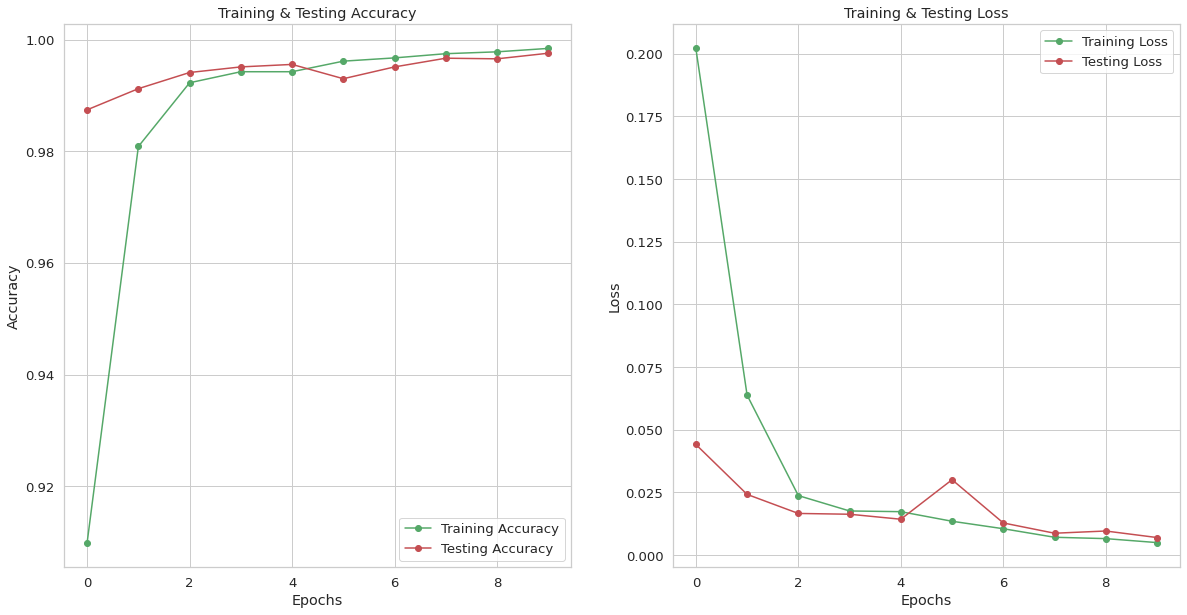

In [ ]:
epoch_list = [i for i in range(epochs)]

fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epoch_list , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epoch_list , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epoch_list , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epoch_list , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
#  pred = model.predict_classes(X_test)
pred = (model.predict(X_test) > 0.5).astype("int32")
confusion_matrix(y_test, pred)

array([[4646,    4],
       [  18, 4312]])

Text(63.5, 0.5, 'Actual')

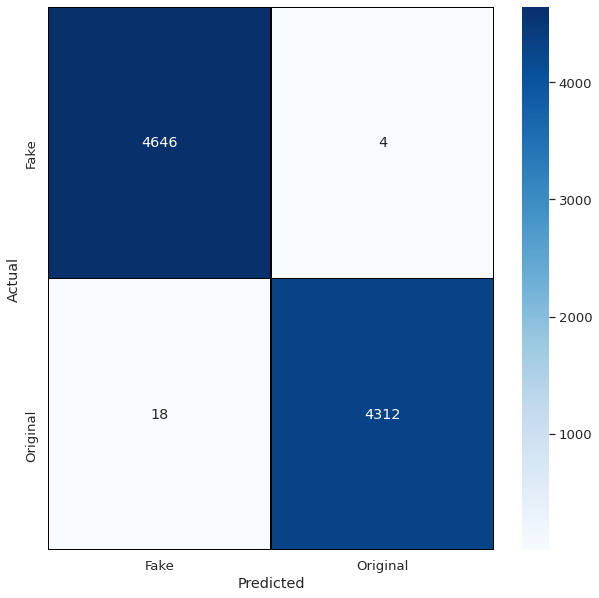

In [ ]:
cm = confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")